# Evaluate Threshold Performance

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os
import pandas as pd
import numpy as np
import sys
import pickle

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from utils.setup import SetupDiagnostics
from utils.variable import Variable_Lev_Metadata
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model, get_path


2024-03-15 11:17:26.224581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
PROJECT_ROOT = Path.cwd().parent.resolve()

base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_76_mask_net_prediction_thresholds")
cfg = os.path.join(base_dir, "cfg_mask_net.yml")
threshold_histories_dir = os.path.join(base_dir, "threshold_histories")

outputs_map_file = os.path.join(base_dir, "outputs_map.txt")

# History data from PreMaskNet 
pre_mask_net_bd = os.path.join(PROJECT_ROOT, "output_castle", "training_74_pre_mask_net_spars0.001")
performance_comparison_dir = os.path.join(pre_mask_net_bd, "history")


In [6]:
# When loading dataframe from tensorboard data:
# perf_comp_df = pd.read_json(performance_comparison_file, orient="split")
# perf_comp_df.columns = pd.MultiIndex.from_tuples(perf_comp_df.columns)

# perf_comp_dict = load_pickle(os.path.join(castle_simplified, "tensorboard", "tensorboard_dict.p"))


In [7]:
def parse_txt_to_dict(txt_file, dict_key="varname"):
    line_dict = dict()
    with open(txt_file, 'r') as f:
        for line in f:
            value, key = line.split(":")
            
            if dict_key == "varname":
                line_dict[key.lstrip().rstrip("\n")] = value.lstrip().rstrip()
            else: 
                line_dict[value.lstrip().rstrip()] = key.lstrip().rstrip("\n")
                
    return line_dict

In [8]:
def load_pickle(p_file):
    with open(p_file, 'rb') as f:
        p_read = pickle.load(f)
    return p_read

In [9]:
def load_history_per_var(dir):
    histories_per_var = dict()
    
    for var_name in output_vars:
        threshold_file = os.path.join(dir, varname2index[var_name] + "_history.p")
    
        histories_per_var[var_name] = load_pickle(threshold_file)
    return histories_per_var


In [10]:
varname2index = parse_txt_to_dict(outputs_map_file)
index2varname = parse_txt_to_dict(outputs_map_file, dict_key="index")

output_vars =list(varname2index.keys())

In [11]:
histories_per_var = load_history_per_var(threshold_histories_dir)
perf_comp_dict = load_history_per_var(performance_comparison_dir)

In [12]:
perf_comp_dict

{'tphystnd-3.64': {'loss': [8.049045391089749e-06,
   4.485412318899762e-06,
   4.1280432014900725e-06,
   2.9759555673081195e-06,
   2.8713482151943026e-06,
   2.7918219984712778e-06,
   2.519901499908883e-06,
   2.4797432160994504e-06,
   2.454288505759905e-06],
  'prediction_loss': [6.580638455488952e-06,
   3.612670980146504e-06,
   3.316722768431646e-06,
   2.3574868919240544e-06,
   2.3354677978204563e-06,
   2.329149083379889e-06,
   2.1235900931060314e-06,
   2.106006149915629e-06,
   2.0942454739270033e-06],
  'sparsity_loss': [0.0014684370253235102,
   0.0008727213134989142,
   0.0008113133953884244,
   0.0006184371886774898,
   0.0005359004135243595,
   0.00046265649143606424,
   0.0003963007766287774,
   0.00037374746170826256,
   0.00036003475543111563],
  'weighted_sparsity_loss': [1.4684384268548456e-06,
   8.727217277737509e-07,
   8.113167382362008e-07,
   6.184386620589066e-07,
   5.359016199690814e-07,
   4.6265850528470764e-07,
   3.9630629089515423e-07,
   3.737538

## Plot threshold losses

In [13]:

def plot_per_threshold(var_name, val=True, ymin=0., ymax=0.1):
    
    # Get data
    loss_per_threshold = dict()
    val_loss_per_threshold = dict()
    
    for t, metric in histories_per_var[var_name].items():
        loss_per_threshold[t] = metric['loss']
        val_loss_per_threshold[t] = metric['val_loss']
        
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    max_epochs = 18

    if val: 
        plot_threshold_loss = val_loss_per_threshold
        train_val = "validation"

        comp_pred_loss = perf_comp_dict[var_name]['val_prediction_loss']
        comp_loss = perf_comp_dict[var_name]['val_loss']
    else:
        plot_threshold_loss = loss_per_threshold
        train_val = "train"

        comp_pred_loss = perf_comp_dict[var_name]['prediction_loss']
        comp_loss = perf_comp_dict[var_name]['loss']
        
        
    for t, values in plot_threshold_loss.items():
        sns.lineplot(x=range(1, len(values)+1), y=values, label=f"{train_val} loss tresholded t={t:.4f}", ax=ax)

    # comp_pred_loss = perf_comp_dict[var_name][train_val]['epoch_prediction_loss']
    # comp_loss = perf_comp_dict[var_name][train_val]['epoch_loss']
    
    sns.lineplot(x=range(1, len(comp_pred_loss)+1), y=comp_pred_loss, label=f"PreMaskNet, {train_val} pred loss", linestyle="dashed", ax=ax)
    sns.lineplot(x=range(1, len(comp_loss)+1), y=comp_loss, label=f"PreMaskNet, {train_val} loss", linestyle="dotted", ax=ax)
                 
    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#DDDDDD')
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=True, left=True)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    ax.margins(x=0.015)
    
    ax.set_ylim(bottom=ymin, top=ymax)
    # ax.set_xticks(range(max_epochs))
    # ax.set_xticklabels(range(max_epochs))
    
    ax.legend(title='Network', loc="lower left") #bbox_to_anchor=(1.01, 0.9))
        
    ax.set_xlabel('Epochs', labelpad=15, color='#333333')
    ax.set_ylabel('Training Loss', labelpad=15, color='#333333')

    if val: 
        ax.set_title(f'Validation Loss per Threshold for {var_name}', pad=15, color='#333333', weight='bold', fontsize=12)
    else: 
        ax.set_title(f'Training Loss per Threshold for {var_name}', pad=15, color='#333333', weight='bold', fontsize=12)

    save_dir = os.path.join(base_dir, "threshold_performance")
    Path(save_dir).mkdir(exist_ok=True, parents=True)
    save_png = f"{train_val}_loss_per_threshold_{var_name}.png"
    plt.savefig(os.path.join(save_dir, save_png), dpi=400, bbox_inches="tight")
    print(f'\nSaving plot {Path(*Path(os.path.join(save_dir, save_png)).parts[-4:])}.')
    
    plt.show()

In [14]:
variable = "tphystnd-820.86"


Saving plot output_castle/training_76_mask_net_prediction_thresholds/threshold_performance/train_loss_per_threshold_tphystnd-820.86.png.


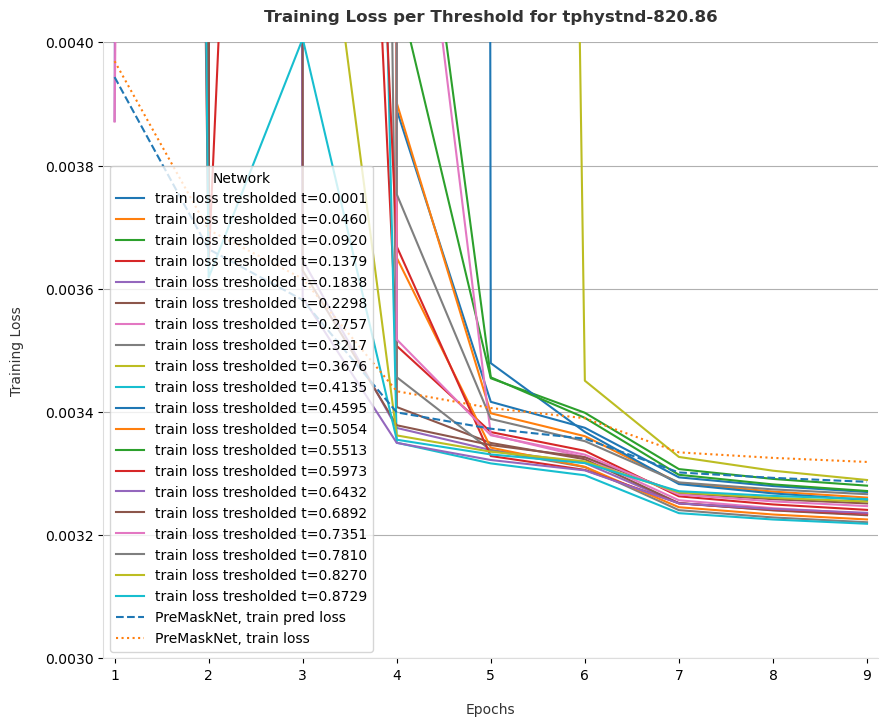

In [15]:
plot_per_threshold(variable, val=False, ymin=0.003, ymax=0.004)


Saving plot output_castle/training_76_mask_net_prediction_thresholds/threshold_performance/validation_loss_per_threshold_tphystnd-820.86.png.


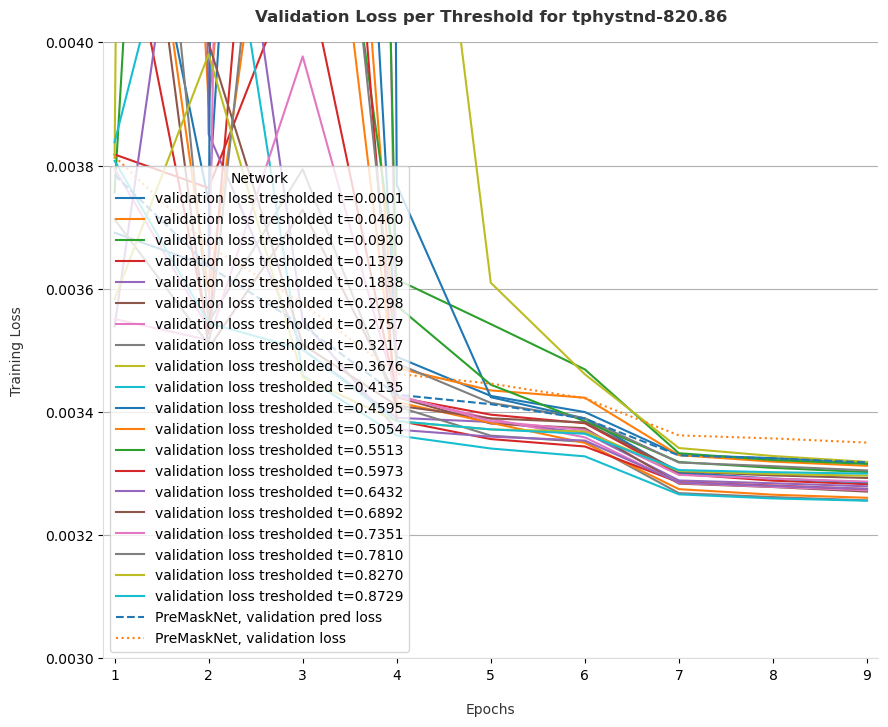

In [16]:
plot_per_threshold(variable, val=True, ymin=0.003, ymax=0.004)



Saving plot output_castle/training_76_mask_net_prediction_thresholds/threshold_performance/train_loss_per_threshold_phq-820.86.png.


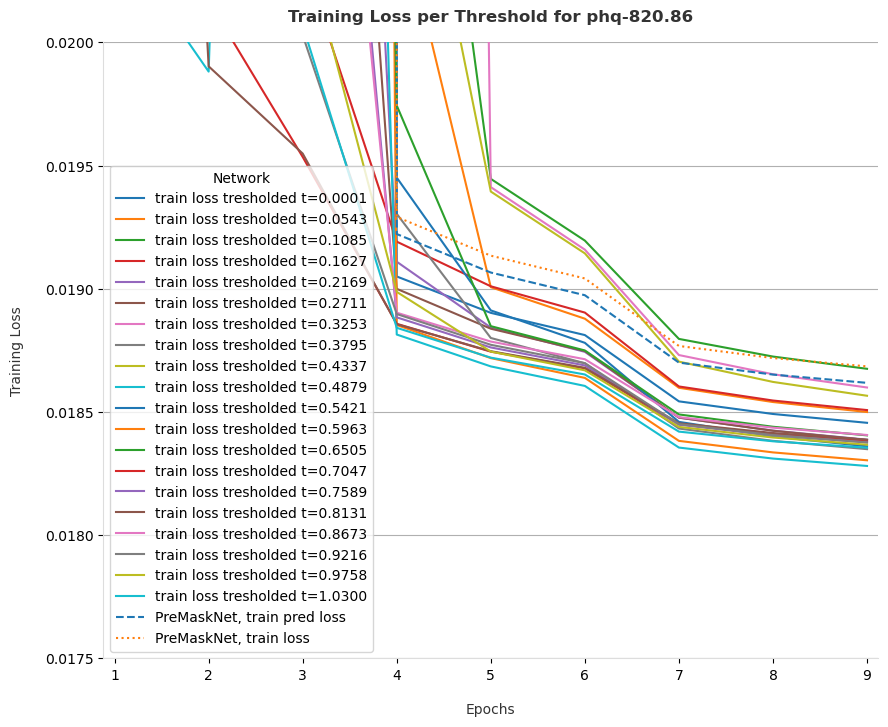

In [17]:
variable = "phq-820.86"
plot_per_threshold(variable, val=False, ymin=0.0175, ymax=0.02)


Saving plot output_castle/training_76_mask_net_prediction_thresholds/threshold_performance/train_loss_per_threshold_prect.png.


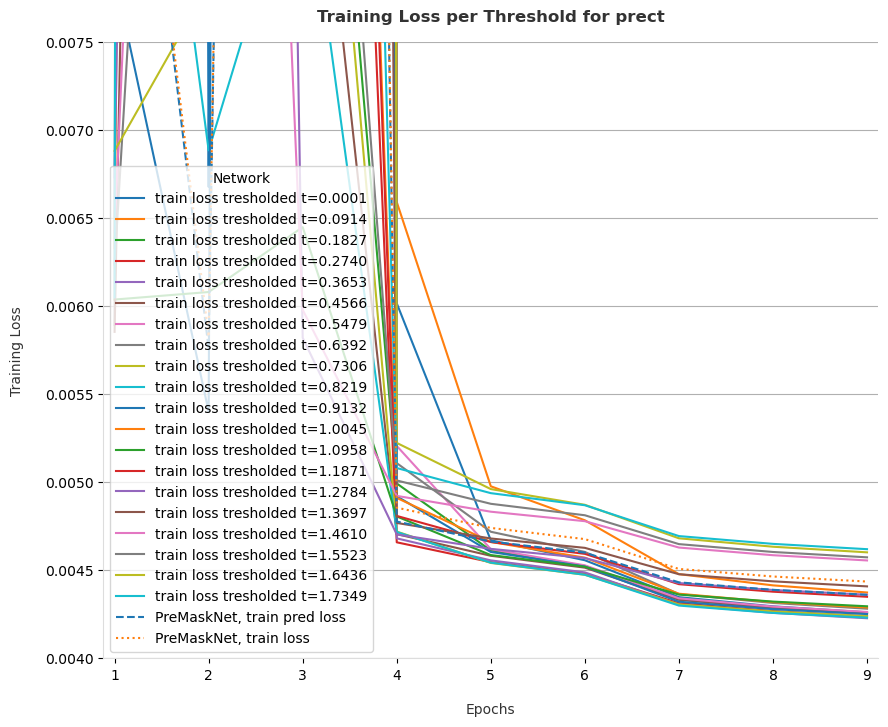

In [18]:
variable = "prect"
plot_per_threshold(variable, val=False, ymin=0.004, ymax=0.0075)

## Min threshold loss 

In [20]:
def get_min_threshold_last_metric_element(d):
    min_key, min_history = min(d.items(), key=lambda x: round(x[1][-1], 6))
    return min_key, min_history[-1]

In [21]:
threshold_per_var_train = dict()
threshold_per_var_val = dict()

for var in output_vars:

    # Get data
    loss_per_threshold = dict()
    val_loss_per_threshold = dict()
    
    for t, metric in histories_per_var[var].items():
        loss_per_threshold[t] = metric['loss']
        val_loss_per_threshold[t] = metric['val_loss']

    t_train, min_train = get_min_threshold_last_metric_element(loss_per_threshold)
    t_val, min_val = get_min_threshold_last_metric_element(val_loss_per_threshold)

    threshold_per_var_train[var] = t_train
    threshold_per_var_val[var] = t_val
    
        
    print(f"\n\nVariable {var}")

    print(f"\nThreshold = {t_train} for best last training loss = {min_train}")
    print(f"Threshold = {t_val} for best last validation loss = {min_val}")


    comp_pred_loss = perf_comp_dict[var]['prediction_loss']
    print(f"\nPreMaskNet training prediction loss = {comp_pred_loss[-1]}")
    val_comp_pred_loss = perf_comp_dict[var]['val_prediction_loss']
    print(f"PreMaskNet validation prediction loss = {val_comp_pred_loss[-1]}\n\n")
   
    # comp_pred_loss = perf_comp_dict[var]["train"]['epoch_prediction_loss']
    # print(f"\nCastleSimplified training prediction loss = {comp_pred_loss[-1]}")
    # val_comp_pred_loss = perf_comp_dict[var]["validation"]['epoch_prediction_loss']
    # print(f"CastleSimplified validation prediction loss = {val_comp_pred_loss[-1]}\n\n")




Variable tphystnd-3.64

Threshold = 0.0001 for best last training loss = 1.3304190815688344e-06
Threshold = 0.0001 for best last validation loss = 1.4401291537069483e-06

PreMaskNet training prediction loss = 2.0942454739270033e-06
PreMaskNet validation prediction loss = 2.1972257400193485e-06




Variable tphystnd-7.59

Threshold = 0.0001 for best last training loss = 1.663623720560281e-06
Threshold = 0.0001 for best last validation loss = 2.026266884058714e-06

PreMaskNet training prediction loss = 2.770447963484912e-06
PreMaskNet validation prediction loss = 3.116136440439732e-06




Variable tphystnd-14.36

Threshold = 0.03372758600234985 for best last training loss = 0.0003573079884517938
Threshold = 0.10098275800704955 for best last validation loss = 0.00037195681943558156

PreMaskNet training prediction loss = 0.00036790448939427733
PreMaskNet validation prediction loss = 0.0003796496312133968




Variable tphystnd-24.61

Threshold = 0.023651540906429288 for best last training

In [22]:
def plot_best_threshold(var_name, ymin=0., ymax=0.1):

    t_train = threshold_per_var_train[var_name]
    t_val = threshold_per_var_val[var_name]
    
    # Get data
    train_loss = histories_per_var[var_name][t_train]['loss']
    val_loss =  histories_per_var[var_name][t_val]['val_loss']

    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    max_epochs = 18
        
    sns.lineplot(x=range(1, len(train_loss)+1), y=train_loss, label=f"training loss tresholded t={t_train:.4f}", ax=ax)
    sns.lineplot(x=range(1, len(val_loss)+1), y=val_loss, label=f"validation loss tresholded t={t_val:.4f}", ax=ax)

    comp_train_pred_loss = perf_comp_dict[var_name]['prediction_loss']
    comp_val_pred_loss = perf_comp_dict[var_name]['val_prediction_loss']
    
    # comp_train_pred_loss = perf_comp_dict[var_name]['train']['epoch_prediction_loss']
    # comp_val_pred_loss = perf_comp_dict[var_name]['validation']['epoch_prediction_loss']

    sns.lineplot(x=range(1, len(comp_train_pred_loss)+1), y=comp_train_pred_loss, label=f"CASTLESimplified, training pred loss", linestyle="dashed", ax=ax)
    sns.lineplot(x=range(1, len(comp_val_pred_loss)+1), y=comp_val_pred_loss, label=f"CASTLESimplified, validation loss", linestyle="dotted", ax=ax)
                 
    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#DDDDDD')
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=True, left=True)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    ax.margins(x=0.015)
    
    ax.set_ylim(bottom=ymin, top=ymax)
    # ax.set_xticks(range(max_epochs))
    # ax.set_xticklabels(range(max_epochs))
    
    ax.legend(title='Network', loc="best") # bbox_to_anchor=(1.01, 1.1))
        
    ax.set_xlabel('Epochs', labelpad=15, color='#333333')
    ax.set_ylabel('Loss', labelpad=15, color='#333333')

    ax.set_title(f'Best Threshold Loss for {var_name}', pad=15, color='#333333', weight='bold', fontsize=12)
    
    save_dir = os.path.join(base_dir, "threshold_performance")
    Path(save_dir).mkdir(exist_ok=True, parents=True)
    save_png = f"best_threshold_loss_{var_name}.png"
    plt.savefig(os.path.join(save_dir, save_png), dpi=400, bbox_inches="tight")
    print(f'\nSaving plot {Path(*Path(os.path.join(save_dir, save_png)).parts[-4:])}.')
    
    plt.show()


Saving plot output_castle/training_76_mask_net_prediction_thresholds/threshold_performance/best_threshold_loss_tphystnd-820.86.png.


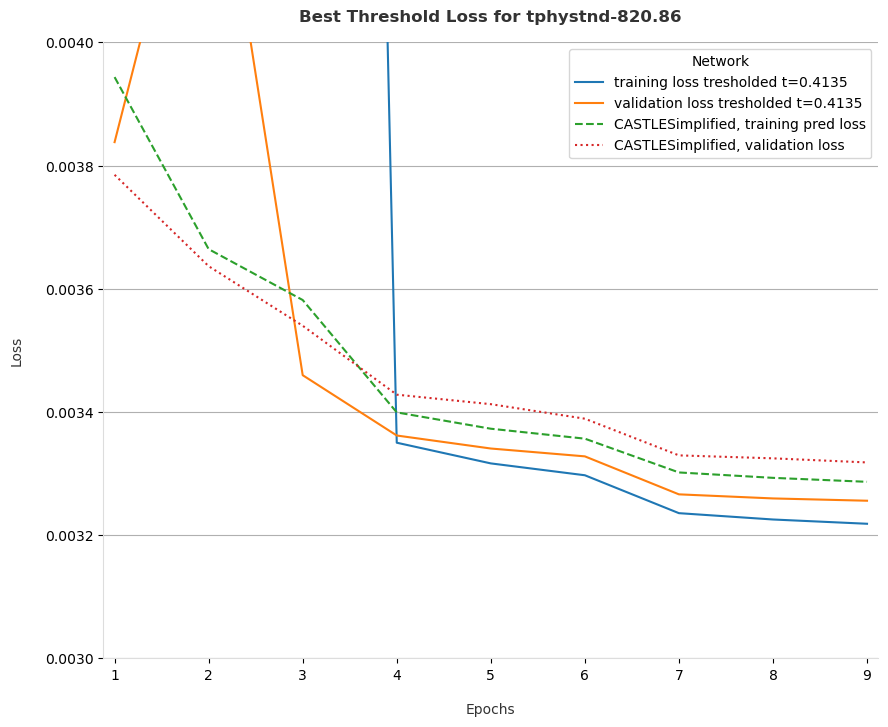

In [23]:
variable = "tphystnd-820.86"
plot_best_threshold(variable, ymin=0.003, ymax=0.004)


Saving plot output_castle/training_76_mask_net_prediction_thresholds/threshold_performance/best_threshold_loss_phq-820.86.png.


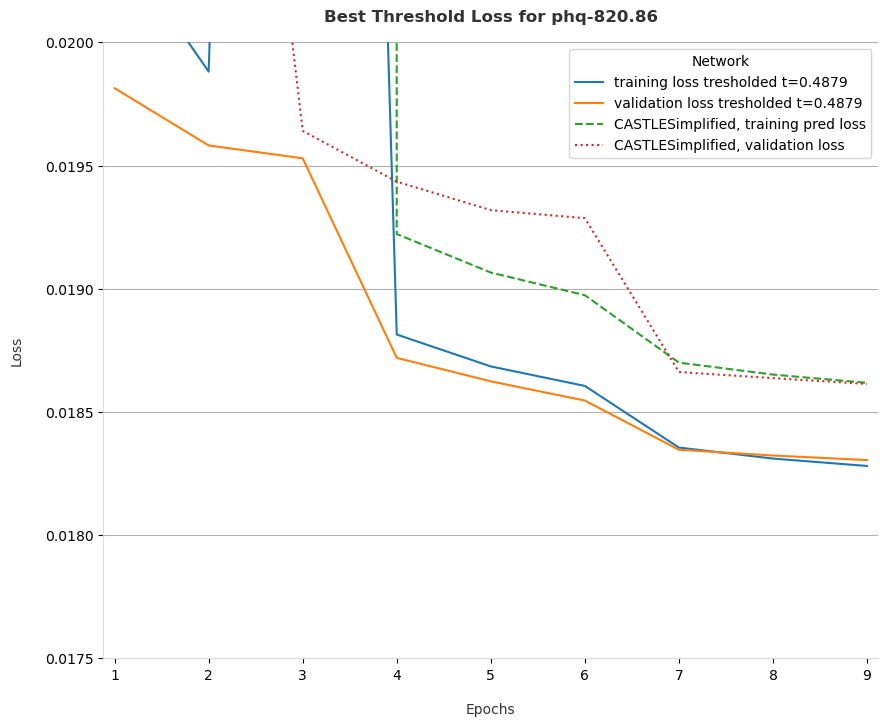

In [24]:
variable = "phq-820.86"
plot_best_threshold(variable, ymin=0.0175, ymax=0.02)


Saving plot output_castle/training_76_mask_net_prediction_thresholds/threshold_performance/best_threshold_loss_prect.png.


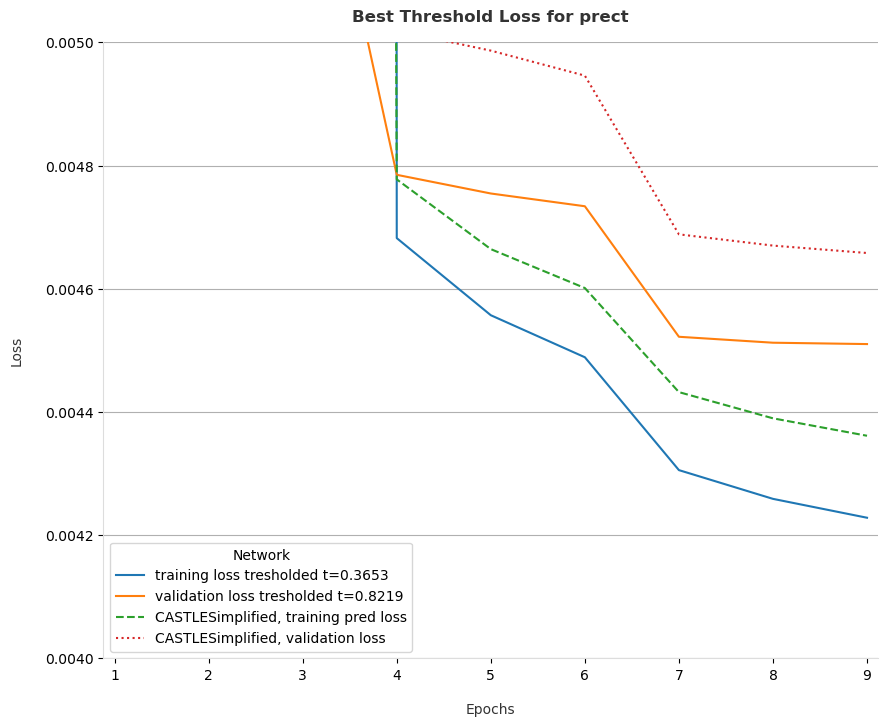

In [25]:
variable = "prect"
plot_best_threshold(variable, ymin=0.004, ymax=0.005)

## Plot number of inputs

In [26]:
causal_dir = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6")
with open(os.path.join(causal_dir, "num_inputs_per_var.p"), "rb") as f:
    causal_sums_per_var = pickle.load(f)

In [27]:
bespoke_dir = os.path.join(PROJECT_ROOT, "output_castle/training_74_pre_mask_net_spars0.001/bespoke_thresholds")
with open(os.path.join(bespoke_dir, "num_inputs_per_var.p"), "rb") as f:
    bespoke_sums_per_var = pickle.load(f)

In [28]:
masking_vector_dir = os.path.join(PROJECT_ROOT, "output_castle/training_74_pre_mask_net_spars0.001/masking_vectors")
masking_vector_per_var = dict()
for var in output_vars: 
    masking_vector = np.load(os.path.join(masking_vector_dir, f"masking_vector_{var}.npy"))
    masking_vector_per_var[var] = masking_vector
                             

In [42]:
def get_sum_inputs_for_threshold(thresholds_per_var):
    sum_per_var = dict()
    
    for var in output_vars:
        t = thresholds_per_var[var]
        masking_vector = masking_vector_per_var[var]
        
        t_vector = np.where(masking_vector < t, 
                            np.zeros_like(masking_vector, dtype=int), # value if condition true 
                            np.ones_like(masking_vector, dtype=int)) # value if condition false
        
        sum_per_var[var] = np.sum(t_vector)

    return sum_per_var

In [43]:
train_num_inputs_per_var = get_sum_inputs_for_threshold(threshold_per_var_train)
val_num_inputs_per_var = get_sum_inputs_for_threshold(threshold_per_var_val)


In [44]:
assert ([str(k) for k in causal_sums_per_var.keys()] == list(train_num_inputs_per_var.keys()))


Saving plot output_castle/training_76_mask_net_prediction_thresholds/threshold_performance/number_of_inputs_per_var.png.


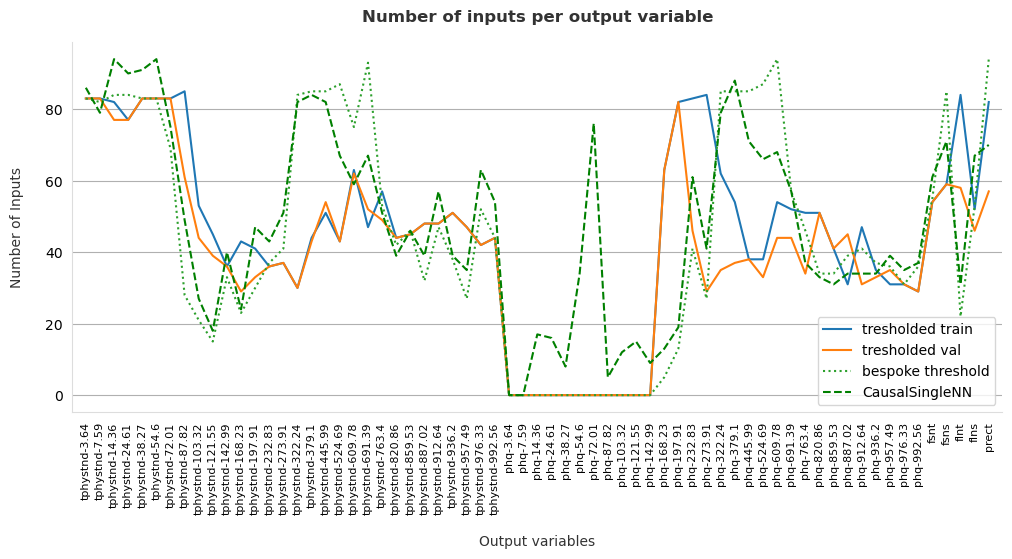

In [49]:
plt.close()
fig, ax = plt.subplots()
fig.set_figwidth(12)


x = range(len(output_vars))

sns.lineplot(x=x, y=train_num_inputs_per_var.values(), label="tresholded train", ax=ax)
sns.lineplot(x=x, y=val_num_inputs_per_var.values(), label="tresholded val", ax=ax)
sns.lineplot(x=x, y=bespoke_sums_per_var.values(), label="bespoke threshold", linestyle="dotted", ax=ax)
sns.lineplot(x=x, y=causal_sums_per_var.values(), label="CausalSingleNN", linestyle="dashed", ax=ax, color='green')
plt.legend()

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=10)
ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.margins(x=0.015)

ax.set_xticks(range(len(output_vars)))
ax.set_xticklabels(output_vars, rotation=90, ha='center', va='top')
    
ax.set_xlabel('Output variables', labelpad=15, color='#333333')
ax.set_ylabel('Number of Inputs', labelpad=15, color='#333333')

ax.set_title('Number of inputs per output variable', pad=15, color='#333333', weight='bold', fontsize=12)

save_dir = os.path.join(base_dir, "threshold_performance")
Path(save_dir).mkdir(exist_ok=True, parents=True)
save_png = f"number_of_inputs_per_var.png"
plt.savefig(os.path.join(save_dir, save_png), dpi=400, bbox_inches="tight")
print(f'\nSaving plot {Path(*Path(os.path.join(save_dir, save_png)).parts[-4:])}.')

plt.show()

## Save Thresholds per var

In [76]:
output_dir = os.path.join(base_dir, "threshold_performance")
Path(output_dir).mkdir(exist_ok=True, parents=True)

In [36]:
def convert_keys_to_variables(per_var_dict):
    new_dict = dict()
    for key, value in per_var_dict.items():
        new_dict[Variable_Lev_Metadata.parse_var_name(key)] = value
    return new_dict

In [83]:
with open(os.path.join(output_dir, "threshold_per_var_train.p"), "wb") as output_file:
    pickle.dump(convert_keys_to_variables(threshold_per_var_train), output_file)
print(f'\nSaved pickle file {Path(*Path(os.path.join(output_dir, "threshold_per_var_train.p")).parts[-4:])}.')



Saved pickle file output_castle/training_76_mask_net_prediction_thresholds/threshold_performance/threshold_per_var_train.p.


In [84]:
with open(os.path.join(output_dir, "threshold_per_var_val.p"), "wb") as output_file:
    pickle.dump(convert_keys_to_variables(threshold_per_var_train), output_file)
print(f'\nSaved pickle file {Path(*Path(os.path.join(output_dir, "threshold_per_var_val.p")).parts[-4:])}.')



Saved pickle file output_castle/training_76_mask_net_prediction_thresholds/threshold_performance/threshold_per_var_val.p.


## Save Num Inputs per var

In [46]:
output_dir = os.path.join(base_dir, "threshold_performance")
Path(output_dir).mkdir(exist_ok=True, parents=True)

In [47]:
with open(os.path.join(output_dir, "num_inputs_per_var_train.p"), "wb") as output_file:
    pickle.dump(convert_keys_to_variables(train_num_inputs_per_var), output_file)
print(f'\nSaved pickle file {Path(*Path(os.path.join(output_dir, "num_inputs_per_var_train.p")).parts[-4:])}.')



Saved pickle file output_castle/training_76_mask_net_prediction_thresholds/threshold_performance/num_inputs_per_var_train.p.


In [48]:
with open(os.path.join(output_dir, "num_inputs_per_var_val.p"), "wb") as output_file:
    pickle.dump(convert_keys_to_variables(val_num_inputs_per_var), output_file)
print(f'\nSaved pickle file {Path(*Path(os.path.join(output_dir, "num_inputs_per_var_val.p")).parts[-4:])}.')


Saved pickle file output_castle/training_76_mask_net_prediction_thresholds/threshold_performance/num_inputs_per_var_val.p.
